#Introduction



In this notebook, we will use a pretrained model to make a prection of a masked token for SMILES representation of a molecule that is in the ClinTox datahase. This tutorial includes visualization tools which help streamline and bring the focus to the masked functional groups as well as the unchanged tokens. 

**Learning Goals for visualization useful for masking token chemical predictions**
1.   Visualize sets of molecules in a compact way using rdkit or matplotlib
2.   Highlight substructures of interest including:(i)  multiple occurences of substructures in same molecule
(ii) partial highlights of desired substructures








#Colab
This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.


<a href="https://colab.research.google.com/github/deloragaskins/data_science_public/blob/main/ChemAsh5_VisualizingMasking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Preamble

In [1]:
 #suppressing output from this cell in colab
%%capture

!pip install --pre deepchem
!pip install rdkit-pypi

#to access ClinTox_
# import MolNet dataloder from bert-loves-chemistry fork
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git
%cd /content/bert-loves-chemistry
!pwd
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

#to play with and display chemical structures
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw as ChemDraw
from rdkit.Chem.Draw import MolToImage

import matplotlib.pyplot as plt
from matplotlib import colors


In [2]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install transformers

from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

import torch

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


In [24]:
#functions to streamline prediction section
def addmask(molecule_str,mask_str,mask_start_pos,mask_end_pos):
  masked=''
  for counter0 in range(len(molecule_str)):
    if mask_len>0:
      if counter0 in range(mask_start_pos,mask_end_pos):
        masked+=''
      elif counter0 == mask_end_pos:
        masked+=mask_str
      else:
        masked+=molecule_str[counter0]
    else:
        masked+=molecule_str[counter0]
  #print(masked)
  return masked

def predict_n(sequence,n):
  input = tokenizer.encode(sequence, return_tensors="pt")
  mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

  token_logits = model(input)[0]
  mask_token_logits = token_logits[0, mask_token_index, :]
  top_n_tokens = torch.topk(mask_token_logits, n, dim=1).indices[0].tolist()
  #print(top_n_tokens)

  valid_mols_list=[]
  for token in top_n_tokens:
    smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
    print (smi)
    smi_mol = Chem.MolFromSmiles(smi)
    if smi_mol is None: # if the model's token prediction isn't chemically feasible
      continue
    valid_mols_list.append((smi))
  return valid_mols_list

################################################################################
#function to select substruct if there are multiple matches
def extract_nth_substructure(substructures,n):
  if len(substructures)>1:
    print('This substructure occurs in multiple places in the molecule')
  elif len(substructures)==1:
    print('This substructure occurs only once in the molecule')
  else:
    print('This substructure does not appear in the molecule.')
  Atoms_list=[]  
  substructure=substructures[n]
  for atom_counter in range(len(substructure)):
    Atoms_list.append(substructure[atom_counter])

  hit_bonds=[]
  for bond in Chem.MolFromSmarts(substructure_smarts).GetBonds():
      aid1 = Atoms_list[bond.GetBeginAtomIdx()]
      aid2 = Atoms_list[bond.GetEndAtomIdx()]
      hit_bonds.append(molecule.GetBondBetweenAtoms(aid1,aid2).GetIdx())
  Bonds_list=hit_bonds
  return Atoms_list,Bonds_list
################################################################################
#functions to support SMILES search with wildcards
wildcard_dict={'l':'atom2','r':'atom2','C':'atom','B':'atom','S':'atom','N':'atom','O':'atom','I':'atom','F':'atom','(':'structure'}

def smiles_masking(char_type):
  if char_type=='bond':
    smiles_mask_char='~'
  if char_type=='atom':
    smiles_mask_char='*'
  if char_type=='ring':
    smiles_mask_char='@'
  return smiles_mask_char

def smile_wildcard_replace(molecule_str,smi,mask_start_pos,mask_end_pos):
  #Cell_label='Display Predictions with Higlighted Original Structure'
  num_characters_added=len(smi)-len(molecule_str)+1
  char_added=smi[mask_end_pos:mask_end_pos+num_characters_added]
  print(char_added)
  
  wildcards_subs=''
  prev_state=''
  
  for char in char_added:
    if wildcard_dict[char] is 'atom2':
      wildcards_subs+=''
    elif wildcard_dict[char] is 'atom':
       wildcards_subs+='*'
    elif char is 'bond':
      wildcards_subs+='~'
    elif char is 'structure':
      wildcards_subs+=char
    else:
      print(char)
      print('error: wildcard_dict does not contain the symbol predicted. Please add manually')
 
  smile_wildcard=molecule_str[:mask_start_pos]
  smile_wildcard=smile_wildcard+wildcards_subs
  smile_wildcard=smile_wildcard+molecule_str[mask_start_pos+num_characters_added-1:]
  return smile_wildcard
################################################################################
#functions to output images

def image_of_nth_substructure(substructure_smarts,molecule_smiles,n):
  m=Chem.MolFromSmiles(molecule_smiles)
  substructures=m.GetSubstructMatches(Chem.MolFromSmarts(substructure_smarts))
  Atoms_list,Bonds_list=extract_nth_substructure(substructures,n)
  hcolor = colors.to_rgb('violet')
  img = MolToImage(m, size=(600, 600),fitImage=True,highlightAtoms=Atoms_list,highlightColor=hcolor)
  return img

def highlighed_wildcard_img(molecule_smiles,substructure_smarts,n,remove_atoms_from_highlight,remove_bonds_from_highlight):
  molecule=Chem.MolFromSmiles(molecule_smiles)
  substructures=molecule.GetSubstructMatches(Chem.MolFromSmarts(substructure_smarts))
  Atoms_list,Bonds_list=extract_nth_substructure(substructures,n)
  for atom in remove_atoms_from_highlight:
    Atoms_list.remove(atom)
  for bond in remove_bonds_from_highlight:
    Bonds_list.remove(bond)
  hcolor = colors.to_rgb('violet')
  img = MolToImage(molecule, size=(600, 600),fitImage=True,highlightAtoms=Atoms_list,highlightBonds=Bonds_list,highlightColor=hcolor)
  return img
################################################################################
#function to support the querying of ClinTox
def canon_smiles(text):
  #Cell_label='Check Clintox for Prediction'
  text=Chem.MolToSmiles(Chem.MolFromSmiles(text))
  return text

#Select a Molecule to make a masked token prediction with from  ClinTox

We load the ClinTox dataset into a dataframe with SMILES representations and toxicity for each molecule.  

In [4]:
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("clintox", tasks_wanted=None)
full_ClinTox_df = train_df.append(valid_df, ignore_index=True)
full_ClinTox_df=full_ClinTox_df.append(test_df, ignore_index=True)


'split' is deprecated.  Use 'splitter' instead.


Using tasks ['CT_TOX'] from available tasks for clintox: ['FDA_APPROVED', 'CT_TOX']


We take a look at the SMILES for the first 25 and visualize their structures

In [5]:
length_peek=25
full_ClinTox_df['text'].head(length_peek)

0         CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O
1     O=C(NCC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(N(CCO...
2                              Clc1cc(Cl)c(OCC#CI)cc1Cl
3     N#Cc1cc(NC(=O)C(=O)[O-])c(Cl)c(NC(=O)C(=O)[O-])c1
4                NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1
5                       NC(N)=[NH+]C(=O)Cc1c(Cl)cccc1Cl
6                         [NH3+]C[C@H](O)c1ccc(O)c(O)c1
7                [NH3+][C@@H](Cc1ccc(O)c(O)c1)C(=O)[O-]
8                                [NH3+]CCc1ccc(O)c(O)c1
9                               Nc1ccc(O)c(C(=O)[O-])c1
10                              Nc1ccc(C(=O)[O-])c(O)c1
11                         NC(N)=[NH+]Cc1cccc([131I])c1
12    O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)[...
13    O=C([O-])CCC(=O)OC[C@@H](NC(=O)[C-](Cl)Cl)[C@H...
14                     [NH3+]CC(CC(=O)[O-])c1ccc(Cl)cc1
15                          Nc1ccc(C(=O)NCC(=O)[O-])cc1
16        [NH3+][C@@H](Cc1ccc(N(CCCl)CCCl)cc1)C(=O)[O-]
17                  [NH3+][C@@H](Cc1ccc(O)cc1)C(

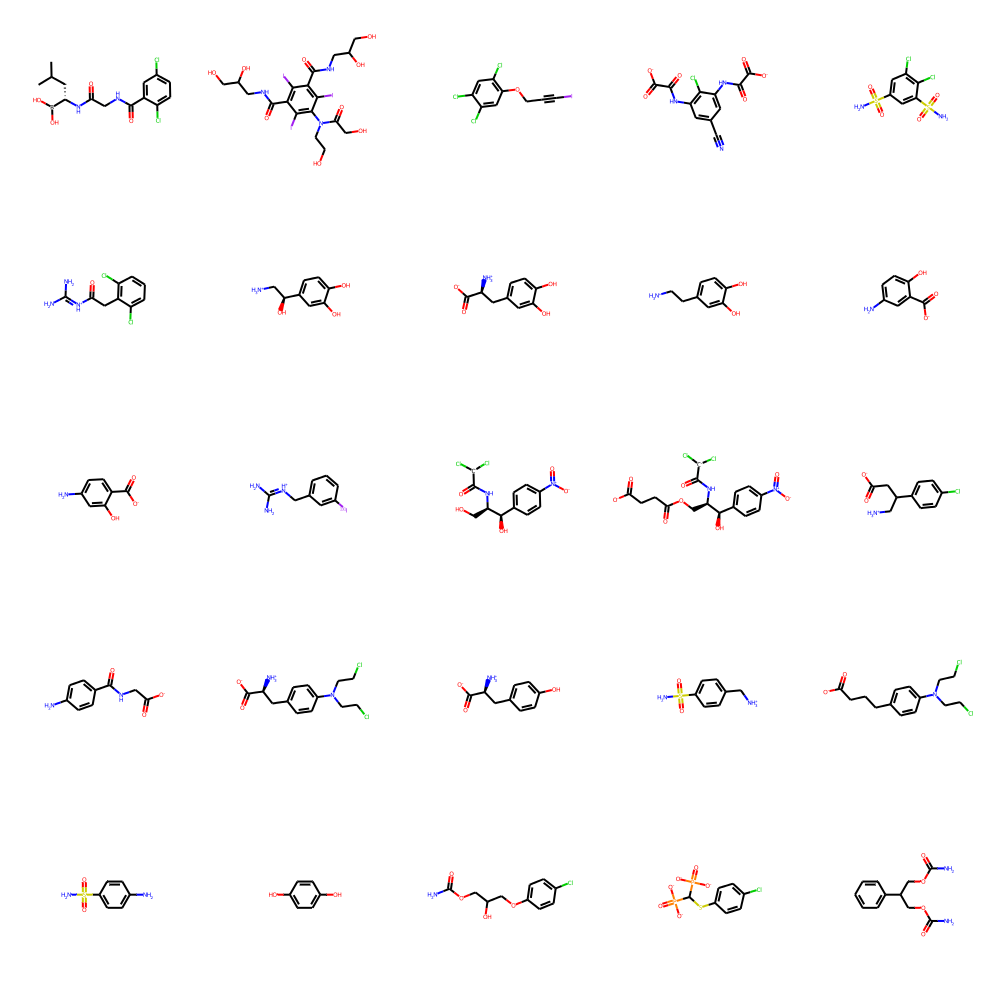

In [6]:

ms = [Chem.MolFromSmiles(x) for x in full_ClinTox_df['text'][:length_peek]]
ChemDraw.MolsToGridImage(ms,molsPerRow=5)

From these structures, we focus on fairly simple molecule for masked token prediction. 

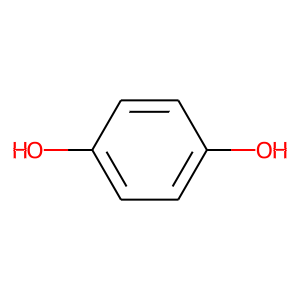

In [7]:
molecule_num=4*5+1
molecule_str=full_ClinTox_df['text'][molecule_num]
molecule=Chem.MolFromSmiles(molecule_str) 
ChemDraw.MolToImage(molecule)

There are two chemically identical substitutions on the aromatic ring here which are represented with different characters in the original SMILES representation. Here we visualize each individually. 

This substructure occurs in multiple places in the molecule
This substructure occurs in multiple places in the molecule


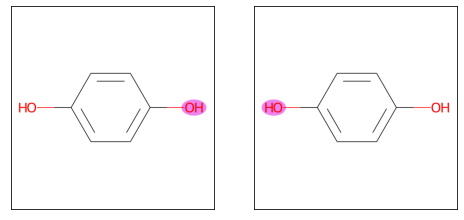

In [22]:
Cell_label='Visualize potential mask sites on molecule'

im_2_show=2

counter0=0 
size_adj_x=2
size_adj_y=4
plt.figure(figsize=(im_2_show*size_adj_y,im_2_show*size_adj_x))

number_of_rows=1
number_of_columns=im_2_show
for counter0 in range(im_2_show):
  plt.subplot(number_of_rows,number_of_columns,counter0+1)

  substructure_smarts='O'
  molecule_smiles=molecule_str
  n2=counter0

  plt.imshow(image_of_nth_substructure(substructure_smarts,molecule_smiles,n2))
  plt.xticks([])
  plt.yticks([])

# Make a masked token prediction and interpret results




Here we select the model for the masked token prediction detailed further in Transfer_Learning_With_ChemBERTa_Transformers notebook in the tutorials. 

We also select to mask the hydroxyl group that is represented in the middle of the SMILES representation for this molecule.

In [8]:
#take pretrained model and define the pipeline
model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

In [23]:
#Make valid predictions for single masked position 
Cell_label='Make Predictions'

mask_start_pos=7
mask_char_type='atom' #'bond' #'atom','ring'

mask_end_pos=mask_start_pos
mask_len=mask_end_pos-mask_start_pos+1
mask_str='<mask>'

smiles_mask=addmask(molecule_str,mask_str,mask_start_pos,mask_end_pos)
replaced=molecule_str[mask_start_pos:mask_end_pos+mask_len]

sequence = smiles_mask.replace('<mask>',tokenizer.mask_token)

print(molecule_str)
print(replaced)

Oc1ccc(O)cc1
O


We show the results of the prediction as both SMILES and chemical structures. In addition, several additional valid structures are predicted.. 

Oc1ccc(O)cc1
Oc1ccc(Cl)cc1
Oc1ccc(Br)cc1
Oc1ccc(I)cc1
Oc1ccc(F)cc1


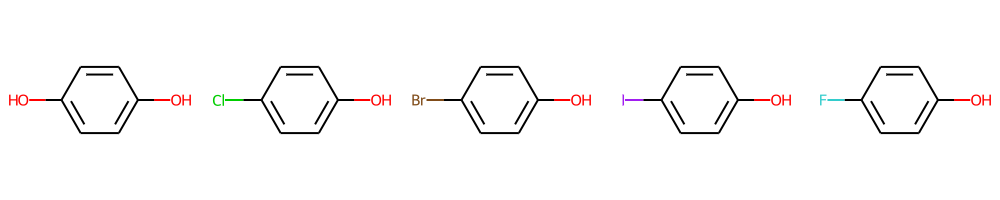

In [21]:
Cell_label='Show Prediction results'
n1=5
valid_smi_list=predict_n(sequence,n1)
valid_mols_list=[Chem.MolFromSmiles(x) for x in valid_smi_list ]

ChemDraw.MolsToGridImage(valid_mols_list,molsPerRow=n1)

We futher examine the first additional structure. Here, we highlight the non-masked atoms and bonds

Oc1ccc(O)cc1
O
Cl
Br
I
F
Oc1ccc(O)cc1
This substructure occurs only once in the molecule
Oc1ccc(*)cc1


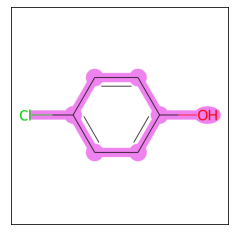

In [19]:
Cell_label='Display Prediction with Higlighted Original Structure'
counter2=1
molecule_smiles=Chem.MolToSmiles(valid_mols_list[counter2]) #select prediction
print(molecule_str)

valid_smiles_list_wildcards=[]
for element in valid_smi_list:
  smile_wildcard=smile_wildcard_replace(molecule_str,element,mask_start_pos,mask_end_pos)
  valid_smiles_list_wildcards.append(smile_wildcard)

print(molecule_str)
substructure_smarts=valid_smiles_list_wildcards[counter2]

n3=0
remove_atoms_from_highlight=[5] #use this to remove atoms from highlight
remove_bonds_from_highlight=[] #range(7) #use this to remove bonds from highlight
img= highlighed_wildcard_img(molecule_smiles,substructure_smarts,n3,remove_atoms_from_highlight,remove_bonds_from_highlight)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
print(substructure_smarts)

We see that this structure in not present in ClinTox but that it does have some toxicity.

In [15]:
Cell_label='Check Clintox for Prediction'

full_ClinTox_df['canonical_smiles']= full_ClinTox_df['text'].apply(canon_smiles)
print(full_ClinTox_df[full_ClinTox_df['canonical_smiles'].str.match(Chem.MolToSmiles(pred_1))])

Empty DataFrame
Columns: [text, labels, canonical_smiles]
Index: []


In [16]:
#Toxicity information for predicted compound
#https://pubchem.ncbi.nlm.nih.gov/compound/4684#section=Toxicity

#Congratulations! Time to join the Community!
Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

#Star DeepChem on Github
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

#Join the DeepChem Gitter
The DeepChem Gitter hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!